In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from keras import Sequential, Model
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, 
    MaxPooling2D, UpSampling2D, Rescaling, Resizing)
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from IPython.display import clear_output

from datetime import datetime
import time

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import preprocess_input

In [3]:
import random
random_seed = 5
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

In [4]:
class PlotLearning(Callback):
    """
    Callback to plot metrics during training
    """
    def __init__(self, showLR=False):
      self.showLR = showLR                

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metric = [x for x in logs if ('val' not in x) and ('lr' not in x)]
        if self.showLR:
          metric.append('lr')
        
        f, axs = plt.subplots(1,len(metric),figsize=(10,4))
        clear_output(wait=True)
        for i,ax in enumerate(axs):
          ax.plot(range(1, epoch + 2), self.metrics[metric[i]],'o--',label=metric[i])
          try:
            ax.plot(range(1, epoch + 2), self.metrics['val_' + metric[i]], 'o--', label='val_' + metric[i])
          except:
            pass
          ax.set_xlabel('# epochs')
          ax.set_ylabel(metric[i])
          ax.legend()
          ax.grid()

        plt.tight_layout()
        plt.show()

In [5]:
def get_model_metrics(test_data, model, model_name):
    """
    Evaluates a binary classification model on test data and reports various performance metrics.
    It calculates the confusion matrix, ROC curve, and several statistical measures including accuracy, 
    sensitivity, specificity, precision, NPV (Negative Predictive Value), PLR (Positive Likelihood Ratio), 
    NLR (Negative Likelihood Ratio), and F1-score. Additionally, it identifies the best threshold for 
    classification based on the max sensitivity within a minimum required specificity.

    The function saves the confusion matrix and ROC curve plots in a local directory, and appends the 
    calculated metrics to a CSV file. This file is created if it doesn't exist, or updated if it does.

    Parameters:
    - test_data (iterable): The test dataset, typically a generator or an iterable that yields batches 
      of images and labels.
    - model (keras.Model): The trained Keras model to evaluate.
    - model_name (str): The name of the model, used for saving output files.

    No return value. The function directly prints the calculated metrics and saves the results and plots 
    to the local file system.
    """
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    results_folder = 'results'
    csv_file = f'{results_folder}/model_performance.csv'
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    predicted_probs = []
    true_labels = []
    for images, labels in test_data:
        predictions = model.predict(images, verbose=0)
        predicted_probs.extend(predictions.flatten())
        true_labels.extend([int(label) for label in labels])
        
    # ROC AUC
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)
    
    # Calculate max sensitivity where specificity is >= 1 - prevalence
    prevalence = sum(true_labels) / len(true_labels)
    
    max_sensitivity = 0
    for i in range(len(fpr)):
        specificity = 1 - fpr[i]
        if specificity >= 1 - prevalence:
            max_sensitivity = max(max_sensitivity, tpr[i])
    print(f"Max Sensitivity at Specificity >= {1 - prevalence:.2f}: {max_sensitivity:.2f}")
    
    # Confusion Matrix
    threshold_for_max_sensitivity = thresholds[np.argmax(tpr == max_sensitivity)]
    final_predicted_labels = [1 if p > threshold_for_max_sensitivity else 0 for p in predicted_probs]
    confusion_mtx = confusion_matrix(true_labels, final_predicted_labels)
    
    # Plot the confusion matrix
    f, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Purples", linecolor="gray", fmt='.1f', ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()
    
    # Classification report
    report = classification_report(true_labels, final_predicted_labels)
    print(report)
    
    # calculate additional metrics
    TP = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 1))
    TN = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 0))
    FP = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 1))
    FN = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 0))

    accuracy = accuracy_score(true_labels, final_predicted_labels)
    sensitivity = recall_score(true_labels, final_predicted_labels)  # recall
    specificity = TN / (TN + FP)
    precision = precision_score(true_labels, final_predicted_labels)  # PPV
    npv = TN / (TN + FN)
    plr = sensitivity / (1 - specificity)
    nlr = (1 - sensitivity) / specificity
    f1_pos_class = f1_score(true_labels, final_predicted_labels)

    # create a DataFrame and append to the CSV file
    df = pd.DataFrame({
        'Model Name': [model_name],
        f'Max Sensitivity at Specificity {1 - prevalence:.2f}': [max_sensitivity],
        'AUC': [roc_auc],
        'F1-Score Positive Class': [f1_pos_class],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'PPV': [precision],
        'NPV': [npv],
        'PLR': [plr],
        'NLR': [nlr]
    }).round(2) 
    
    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)

    print(df)
    
    # Plotting and saving ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [6]:
def build_model(base_model, transfer_learning):
    """
    Constructs a neural network model based on a specified base model and a transfer learning option.

    This function initializes a new model by setting the base model's trainable parameter according to 
    the transfer_learning flag ('Y' for non-trainable and 'N' for trainable). It modifies the input 
    layer to accommodate grayscale images and expands the single channel to three channels using a 
    Conv2D layer. The function then applies the base model and adds additional top layers for classification. 
    It returns the newly created model, which is suitable for binary classification tasks.

    Parameters:
    - base_model (keras.Model): The pre-existing model to use as the base.
    - transfer_learning (str): A flag ('Y' or 'N') indicating whether to freeze (non-trainable) or unfreeze 
      (trainable) the layers of the base model for transfer learning.

    Returns:
    - keras.Model: The constructed model ready for training.
    """
    # Set the base_model to be trainable or non-trainable
    if transfer_learning == 'Y':
        base_model.trainable = False
    elif transfer_learning == 'N':
        base_model.trainable = True
    print('base_model.trainable set to', base_model.trainable)

    # Define a new input layer for grayscale images
    input_layer = Input(shape=(224, 224, 1), name='grayscale_input')

    # Add a Conv2D layer to expand the single channel to three channels
    x = Conv2D(3, (3, 3), padding='same')(input_layer)

    # Add the rest of the model
    x = base_model(x)

    # Add own top layers for classification
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create the new model
    model = Model(inputs=input_layer, outputs=outputs)

    return model

In [7]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/peso-11-mask-v2/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/peso-11-mask-v2/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/peso-11-mask-v2/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 518 files belonging to 2 classes.
Found 90 files belonging to 2 classes.
Found 453 files belonging to 2 classes.


In [8]:
METRICS = [
       keras.metrics.AUC(name='auc'),
]

# CLASS WEIGHTS

In [9]:
from sklearn.utils.class_weight import compute_class_weight

labels = []
for _, label in train_data:
    labels.extend(label.numpy())

# Convert the labels to a NumPy array
labels = np.array(labels)

total_samples = len(labels)
class_labels, class_counts = np.unique(labels, return_counts=True)
# class_weights = total_samples / (len(class_labels) * class_counts)
class_weights = [1 - class_counts[0] / total_samples, 1 - class_counts[1] / total_samples]

# Create a dictionary for class weights
class_weights_dict = dict(zip(class_labels, class_weights))
class_weights_dict = {int(key): value for key, value in class_weights_dict.items()}

In [10]:
class_weights_dict

{0: 0.16216216216216217, 1: 0.8378378378378378}

# IMAGE AUGMENTATION

In [11]:
def augment_image(image, label):
    # Randomly apply different augmentations to the image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)  # Adjust brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Adjust contrast
    return image, label

# MODELO BASE ANN

In [12]:
# Apply the augmentation to the training dataset
train_data_augmented = train_data.map(augment_image)

### With class weights

In [13]:
basic_model = ''
# Definición de la red
basic_model = Sequential([
    # resizing
    Resizing(224,224, input_shape=(224, 224, 1)),
    # rescaling
    Rescaling(scale=1./255),
    # flatten
    Flatten(),
    # capa conectada
    Dense(1024, activation='relu'),
    # dropout
    Dropout(0.5),
    # capa de salida conectada
    Dense(1, activation='sigmoid')
])

In [14]:
basic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 1)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 1)       0         
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1024)              51381248  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 51382273 (196.01 MB)
Trainable params: 513

In [15]:
# Compilación de la red
basic_model.compile(loss='binary_crossentropy', 
                    optimizer=Adam(learning_rate=1e-4), 
                    metrics=METRICS)

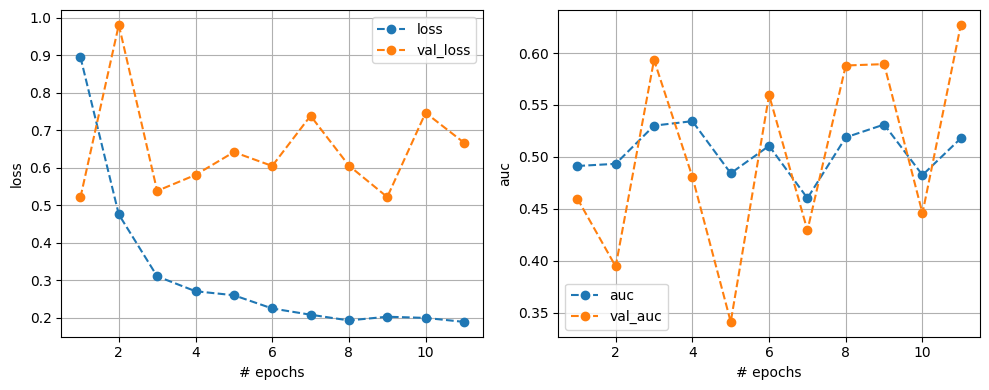

17/17 [==============================] - 3s 104ms/step - loss: 0.1894 - auc: 0.5180 - val_loss: 0.6673 - val_auc: 0.6271
Training time: 33.293500900268555 seconds


In [16]:
# Entrenamiento de la red
ann_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
ann_checkpoint = ModelCheckpoint('ann_best_weights.h5', save_best_only=True, save_weights_only=True)
ann_plot_callback = PlotLearning()

start = time.time()

history = basic_model.fit(train_data_augmented,#train_generator,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    epochs=150, 
                    batch_size=32,
                    callbacks=[ann_callback, ann_checkpoint, ann_plot_callback],
                    class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Max Sensitivity at Specificity >= 0.84: 0.19


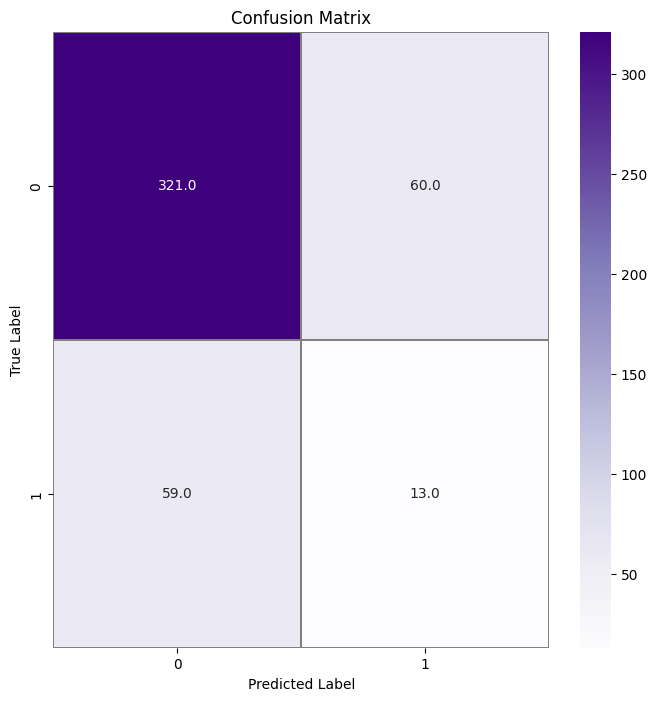

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       381
           1       0.18      0.18      0.18        72

    accuracy                           0.74       453
   macro avg       0.51      0.51      0.51       453
weighted avg       0.74      0.74      0.74       453

  Model Name  Max Sensitivity at Specificity 0.84   AUC  \
0        ANN                                 0.19  0.51   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                     0.18      0.74         0.18         0.84  0.18  0.84   

    PLR   NLR  
0  1.15  0.97  


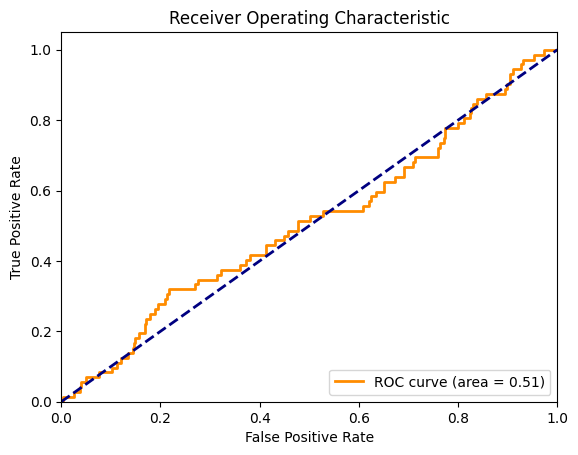

In [17]:
get_model_metrics(test_data=test_data, model=basic_model, model_name='ANN')

### Without class weights

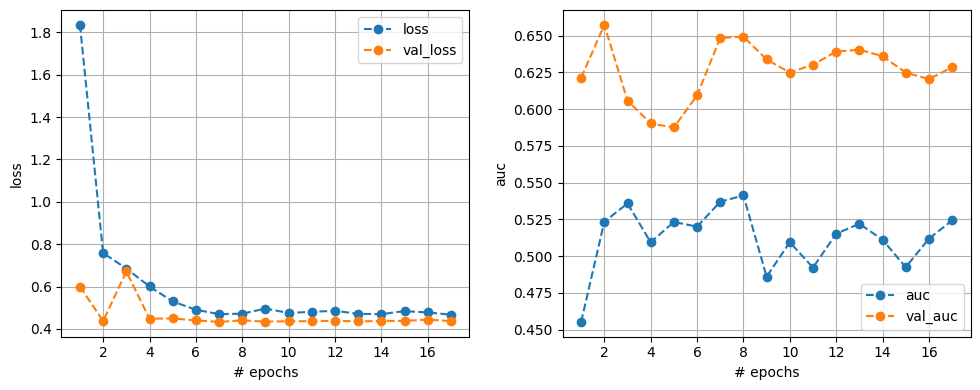

17/17 [==============================] - 3s 104ms/step - loss: 0.4672 - auc: 0.5242 - val_loss: 0.4367 - val_auc: 0.6284
Training time: 45.71173715591431 seconds


In [18]:
basic_model = ''
# Definición de la red
basic_model = Sequential([
    # resizing
    Resizing(224,224, input_shape=(224, 224, 1)),
    # rescaling
    Rescaling(scale=1./255),
    # flatten
    Flatten(),
    # capa conectada
    Dense(1024, activation='relu'),
    # dropout
    Dropout(0.5),
    # capa de salida conectada
    Dense(1, activation='sigmoid')
])

# Compilación de la red
basic_model.compile(loss='binary_crossentropy', 
                    optimizer=Adam(learning_rate=1e-4), 
                    metrics=METRICS)

# Entrenamiento de la red
ann_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
ann_checkpoint = ModelCheckpoint('ann_best_weights.h5', save_best_only=True, save_weights_only=True)
ann_plot_callback = PlotLearning()

start = time.time()

history = basic_model.fit(train_data_augmented, #train_generator,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    epochs=150, 
                    batch_size=32,
                    callbacks=[ann_callback, ann_checkpoint, ann_plot_callback],
                   # class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Max Sensitivity at Specificity >= 0.84: 0.22


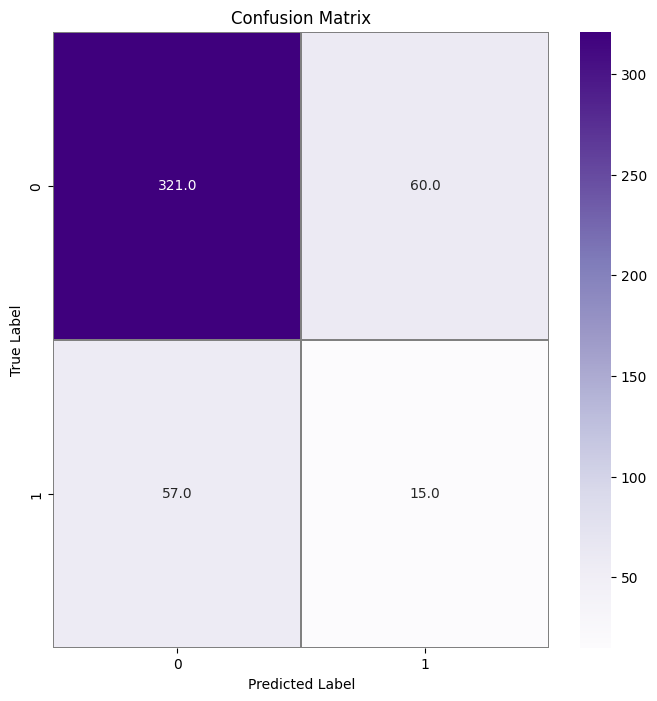

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       381
           1       0.20      0.21      0.20        72

    accuracy                           0.74       453
   macro avg       0.52      0.53      0.52       453
weighted avg       0.75      0.74      0.74       453

  Model Name  Max Sensitivity at Specificity 0.84   AUC  \
0  ANN-no-CW                                 0.22  0.52   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV  \
0                      0.2      0.74         0.21         0.84  0.2  0.85   

    PLR   NLR  
0  1.32  0.94  


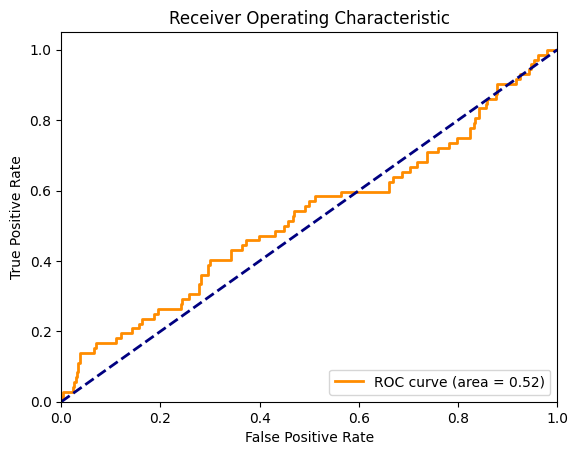

In [19]:
get_model_metrics(test_data=test_data, model=basic_model, model_name='ANN-no-CW')

# VGG16 NO TRANSFER LEARNING

In [20]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [21]:
# preprocesar input
def convert_to_rgb(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.grayscale_to_rgb(image)
    return grayscale_image, label

train_data_rgb = train_data.map(convert_to_rgb)
val_data_rgb = val_data.map(convert_to_rgb)
test_data_rgb = test_data.map(convert_to_rgb)

prep_train_data = train_data_rgb.map(lambda x, y: (preprocess_input(x), y))
prep_val_data = val_data_rgb.map(lambda x, y: (preprocess_input(x), y))
prep_test_data = test_data_rgb.map(lambda x, y: (preprocess_input(x), y))

def convert_to_grayscale(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image, label

# Apply to datasets
prep_train_data = prep_train_data.map(convert_to_grayscale)
prep_val_data = prep_val_data.map(convert_to_grayscale)
prep_test_data = prep_test_data.map(convert_to_grayscale)

In [22]:
train_data_augmented = prep_train_data.map(augment_image)

### With class weights

In [23]:
# cargar modelo
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model_VGG16 = build_model(base_model=base_model_VGG16, transfer_learning='N')

# Model summary
model_VGG16.summary()

58889256/58889256 [==============================] - 0s 0us/step
base_model.trainable set to True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grayscale_input (InputLaye  [(None, 224, 224, 1)]     0         
 r)                                                              
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                             

In [24]:
# Compilación de la red
model_VGG16.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

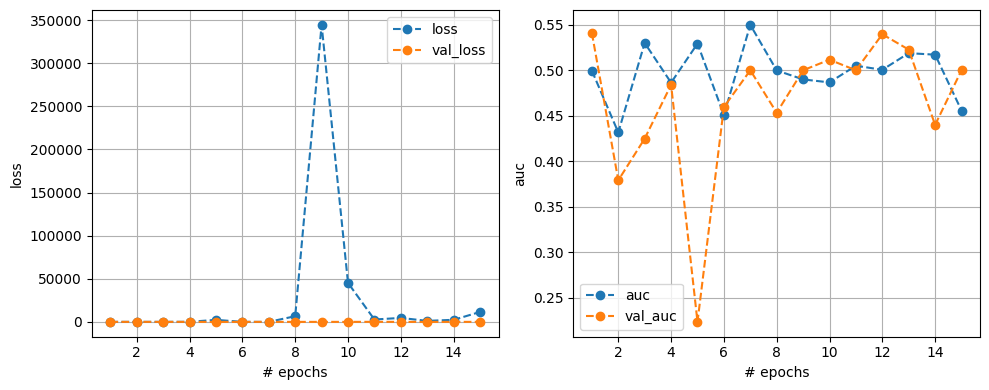

17/17 [==============================] - 5s 267ms/step - loss: 11453.0273 - auc: 0.4557 - val_loss: 18.7233 - val_auc: 0.5000
Training time: 115.15242338180542 seconds


In [25]:
# Entrenamiento de la red
vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
vgg_tl_plot_callback = PlotLearning()

start = time.time()

history = model_VGG16.fit(train_data_augmented, #train_generator,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[vgg_tl_callback, vgg_tl_checkpoint, vgg_tl_plot_callback],
                    class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Max Sensitivity at Specificity >= 0.84: 0.00


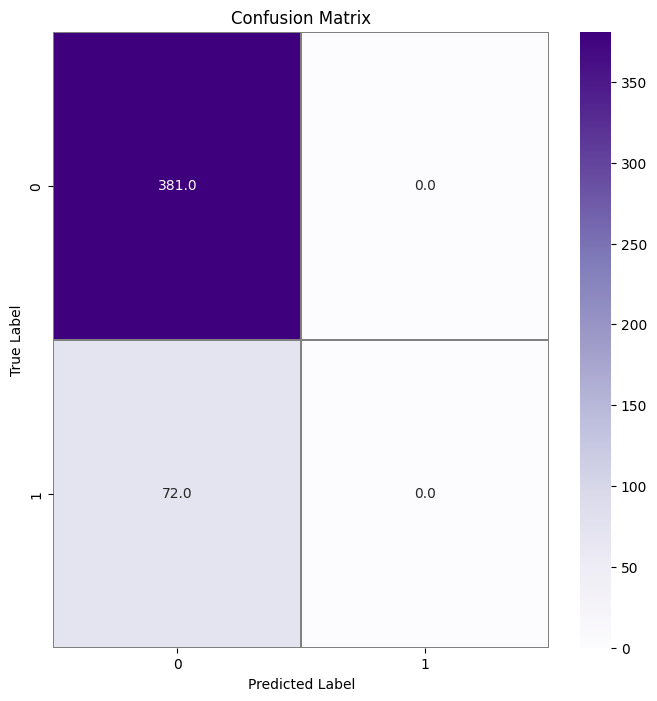

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       381
           1       0.00      0.00      0.00        72

    accuracy                           0.84       453
   macro avg       0.42      0.50      0.46       453
weighted avg       0.71      0.84      0.77       453

    Model Name  Max Sensitivity at Specificity 0.84  AUC  \
0  VGG16-no-TL                                    0  0.5   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV  \
0                      0.0      0.84          0.0          1.0  0.0  0.84   

   PLR  NLR  
0  NaN  1.0  


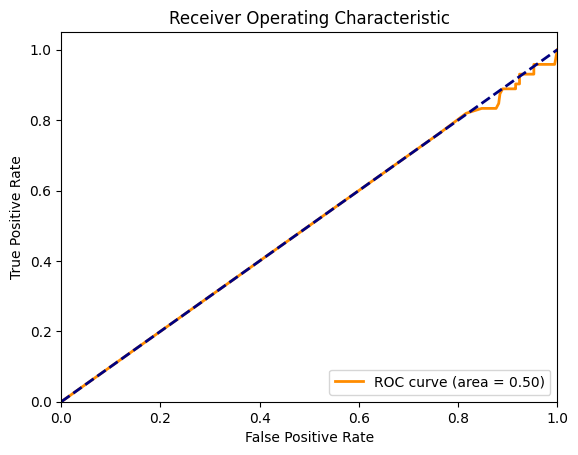

In [26]:
get_model_metrics(test_data=prep_test_data, model=model_VGG16, model_name='VGG16-no-TL')

### Without class weights

In [27]:
# cargar modelo
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model_VGG16 = build_model(base_model=base_model_VGG16, transfer_learning='N')

# Compilación de la red
model_VGG16.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to True


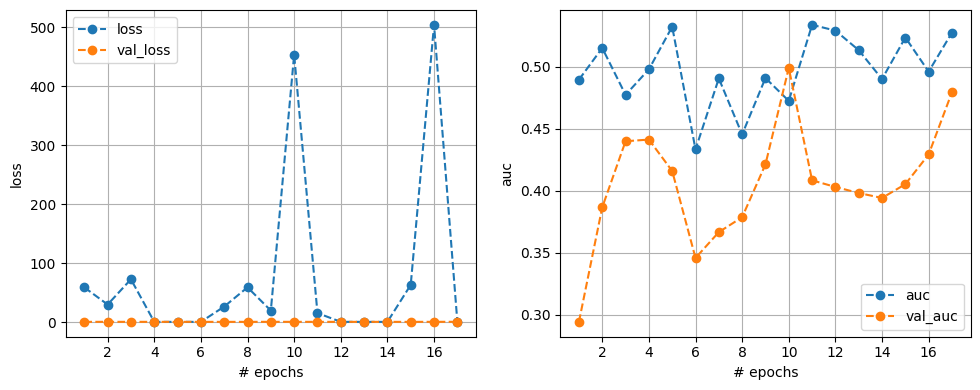

17/17 [==============================] - 6s 268ms/step - loss: 0.5815 - auc: 0.5277 - val_loss: 0.6122 - val_auc: 0.4796
Training time: 110.3314151763916 seconds


In [28]:
# Entrenamiento de la red
vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
vgg_tl_plot_callback = PlotLearning()

start = time.time()

history = model_VGG16.fit(train_data_augmented,#train_generator,
                    steps_per_epoch=len(train_data),
                    epochs=150,
                    validation_data=prep_val_data,
                    callbacks=[vgg_tl_callback, vgg_tl_checkpoint, vgg_tl_plot_callback],
                    #class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Max Sensitivity at Specificity >= 0.84: 0.25


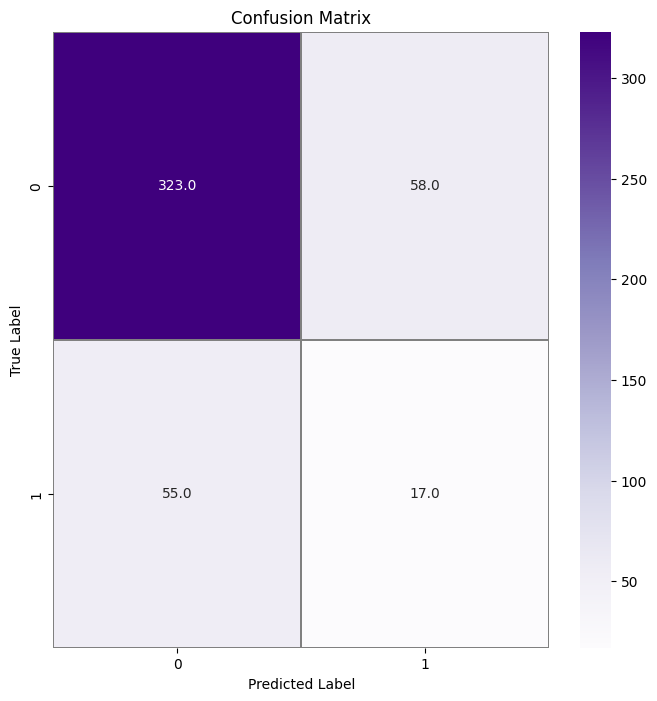

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       381
           1       0.23      0.24      0.23        72

    accuracy                           0.75       453
   macro avg       0.54      0.54      0.54       453
weighted avg       0.75      0.75      0.75       453

          Model Name  Max Sensitivity at Specificity 0.84   AUC  \
0  VGG16-no-TL-no-CW                                 0.25  0.55   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                     0.23      0.75         0.24         0.85  0.23  0.85   

    PLR  NLR  
0  1.55  0.9  


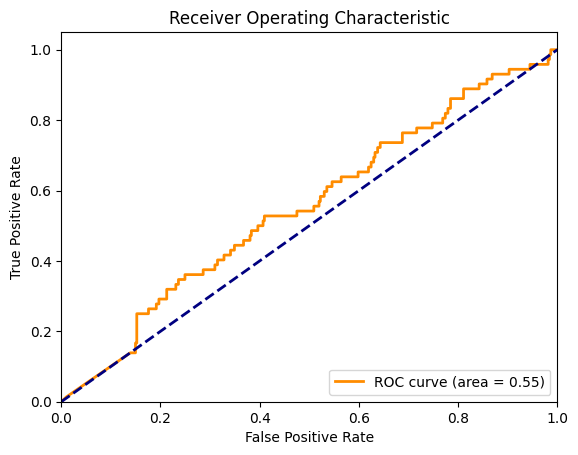

In [29]:
get_model_metrics(test_data=prep_test_data, model=model_VGG16, model_name='VGG16-no-TL-no-CW')

# VGG TRANSFER LEARNING

### With class weights

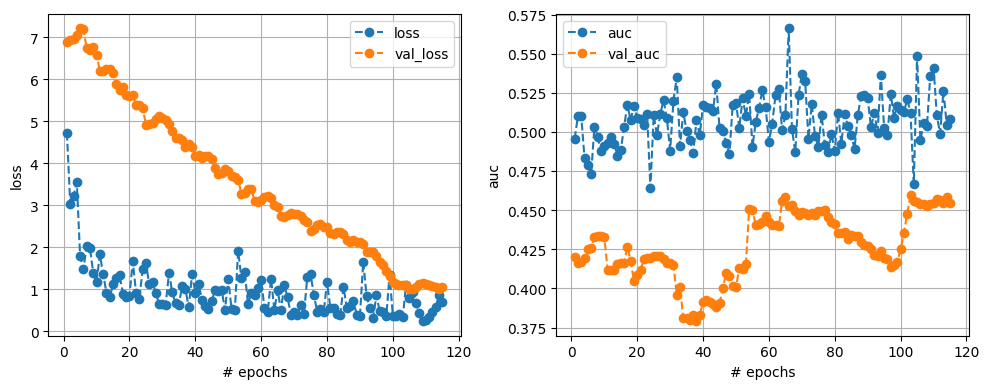

17/17 [==============================] - 4s 210ms/step - loss: 0.6835 - auc: 0.5080 - val_loss: 1.0412 - val_auc: 0.4547
Training time: 550.7704141139984 seconds


In [30]:
# cargar modelo
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model_VGG16 = build_model(base_model=base_model_VGG16, transfer_learning='Y')
model_VGG16.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

# Entrenamiento de la red
vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
vgg_tl_plot_callback = PlotLearning()

start = time.time()

history = model_VGG16.fit(train_data_augmented,
                    steps_per_epoch=len(train_data),
                    epochs=150,
                    validation_data=prep_val_data,
                    callbacks=[vgg_tl_callback, vgg_tl_checkpoint, vgg_tl_plot_callback],
                    class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Max Sensitivity at Specificity >= 0.84: 0.17


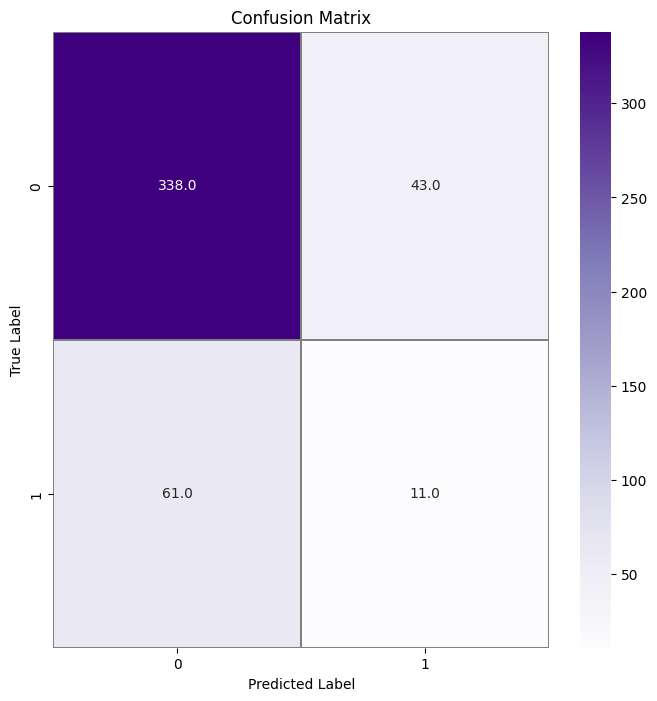

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       381
           1       0.20      0.15      0.17        72

    accuracy                           0.77       453
   macro avg       0.53      0.52      0.52       453
weighted avg       0.74      0.77      0.76       453

  Model Name  Max Sensitivity at Specificity 0.84  AUC  \
0   VGG16-TL                                 0.17  0.5   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity  PPV   NPV  \
0                     0.17      0.77         0.15         0.89  0.2  0.85   

    PLR   NLR  
0  1.35  0.96  


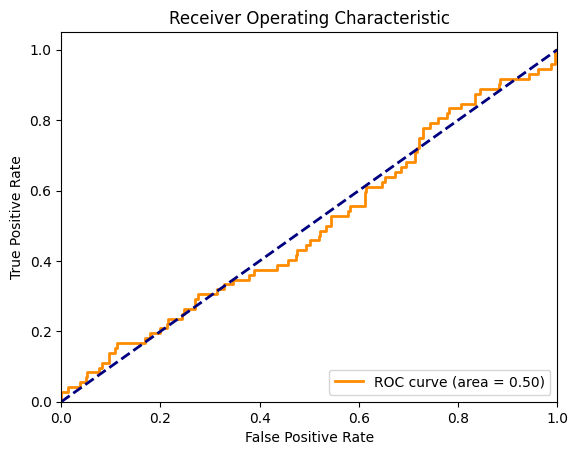

In [31]:
get_model_metrics(test_data=prep_test_data, model=model_VGG16, model_name='VGG16-TL')

### Without class weights

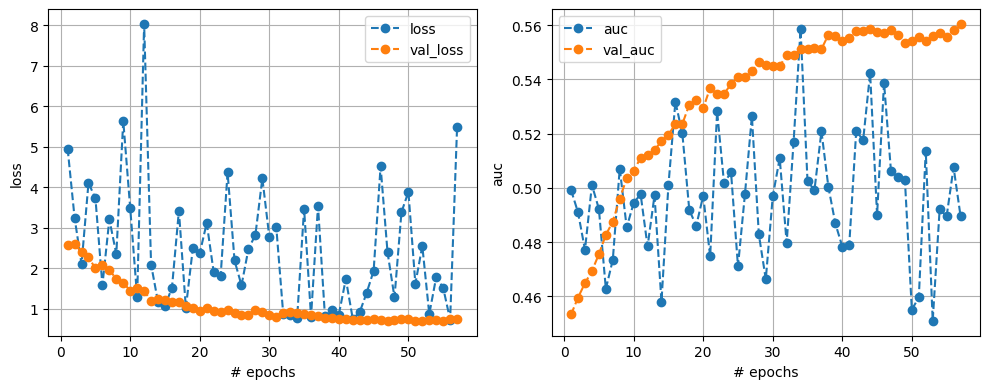

17/17 [==============================] - 4s 211ms/step - loss: 5.4908 - auc: 0.4897 - val_loss: 0.7483 - val_auc: 0.5604
Training time: 272.18556785583496 seconds


In [32]:
# cargar modelo
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model_VGG16 = build_model(base_model=base_model_VGG16, transfer_learning='Y')
model_VGG16.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

# Entrenamiento de la red
vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
vgg_tl_plot_callback = PlotLearning()

start = time.time()

history = model_VGG16.fit(train_data_augmented,
                    steps_per_epoch=len(train_data),
                    epochs=150,
                    validation_data=prep_val_data,
                    callbacks=[vgg_tl_callback, vgg_tl_checkpoint, vgg_tl_plot_callback],
                    #class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Max Sensitivity at Specificity >= 0.84: 0.19


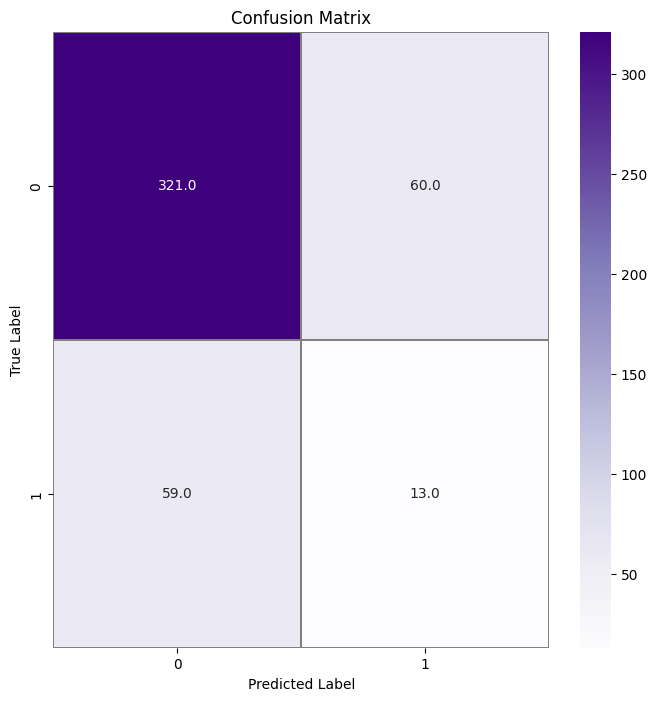

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       381
           1       0.18      0.18      0.18        72

    accuracy                           0.74       453
   macro avg       0.51      0.51      0.51       453
weighted avg       0.74      0.74      0.74       453

       Model Name  Max Sensitivity at Specificity 0.84   AUC  \
0  VGG16-TL-no-CW                                 0.19  0.57   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                     0.18      0.74         0.18         0.84  0.18  0.84   

    PLR   NLR  
0  1.15  0.97  


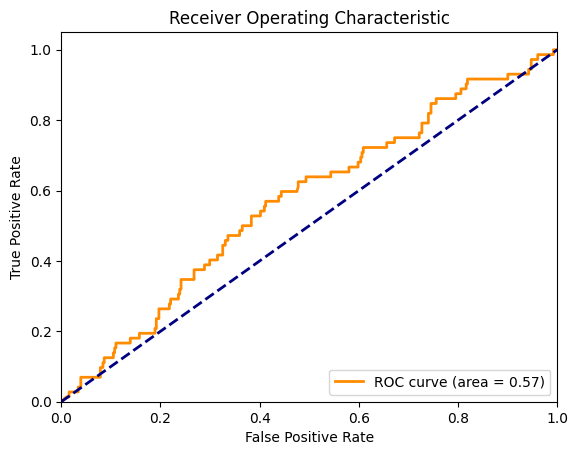

In [33]:
get_model_metrics(test_data=prep_test_data, model=model_VGG16, model_name='VGG16-TL-no-CW')

# RESNET50 NO TRANSFER LEARNING

In [34]:
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50

In [35]:
def preprocess_data_resnet50(image, label):
    # Preprocess the image for MobileNet
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

In [36]:
train_data_rgb = train_data.map(convert_to_rgb)
val_data_rgb = val_data.map(convert_to_rgb)
test_data_rgb = test_data.map(convert_to_rgb)

In [37]:
# Map the preprocessing function to the datasets
prep_train_data = train_data_rgb.map(preprocess_data_resnet50)
prep_val_data = val_data_rgb.map(preprocess_data_resnet50)
prep_test_data = test_data_rgb.map(preprocess_data_resnet50)

In [38]:
# back to grayscale
prep_train_data = prep_train_data.map(convert_to_grayscale)
prep_val_data = prep_val_data.map(convert_to_grayscale)
prep_test_data = prep_test_data.map(convert_to_grayscale)

In [39]:
train_data_augmented = prep_train_data.map(augment_image)

### With class weights

In [40]:
# cargar modelo
base_model_resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model_resnet50 = build_model(base_model=base_model_resnet50, transfer_learning='N')

# Model summary
model_resnet50.summary()

94765736/94765736 [==============================] - 0s 0us/step
base_model.trainable set to True
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grayscale_input (InputLaye  [(None, 224, 224, 1)]     0         
 r)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 3)       30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 1)                 2049      
                           

In [41]:
# Compilación de la red
model_resnet50.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

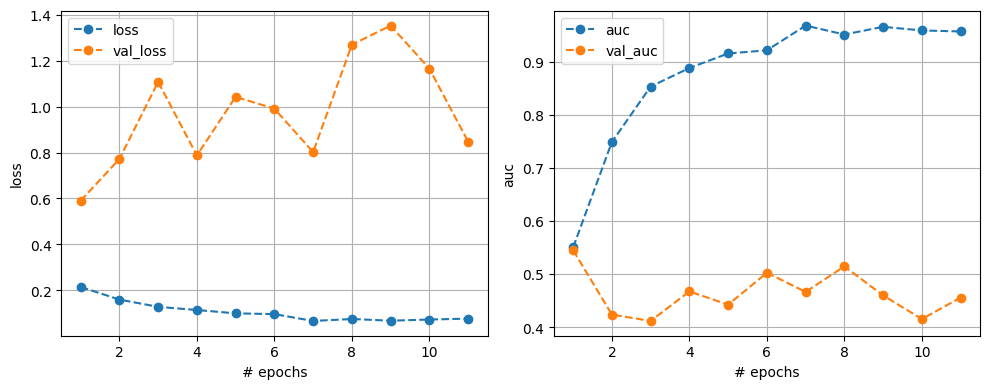

17/17 [==============================] - 5s 240ms/step - loss: 0.0767 - auc: 0.9566 - val_loss: 0.8474 - val_auc: 0.4560
Training time: 94.151540517807 seconds


In [42]:
# Entrenamiento de la red
resnet_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
resnet_checkpoint = ModelCheckpoint('resnet50_best_weights.h5', save_best_only=True, save_weights_only=True)
resnet_plot_callback = PlotLearning()

start = time.time()

history = model_resnet50.fit(train_data_augmented, 
                    epochs=150, 
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data, 
                    callbacks=[resnet_callback, resnet_checkpoint, resnet_plot_callback],
                    class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Max Sensitivity at Specificity >= 0.84: 0.10


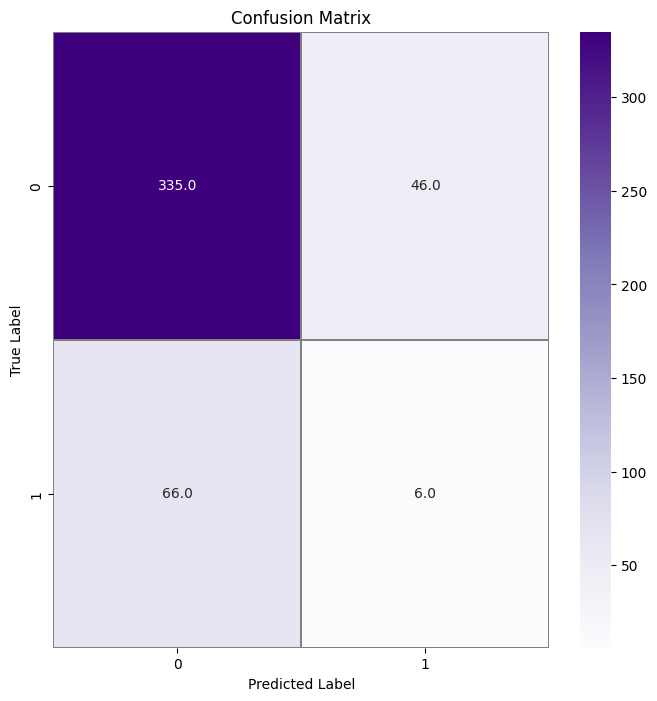

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       381
           1       0.12      0.08      0.10        72

    accuracy                           0.75       453
   macro avg       0.48      0.48      0.48       453
weighted avg       0.72      0.75      0.74       453

       Model Name  Max Sensitivity at Specificity 0.84   AUC  \
0  ResNet50-no-TL                                  0.1  0.48   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                      0.1      0.75         0.08         0.88  0.12  0.84   

    PLR   NLR  
0  0.69  1.04  


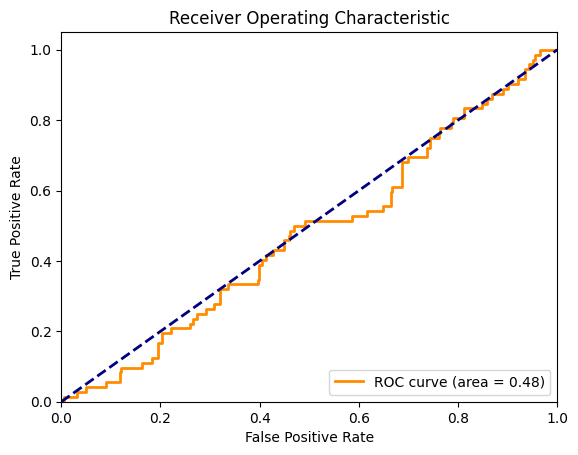

In [43]:
get_model_metrics(test_data=prep_test_data, model=model_resnet50, model_name='ResNet50-no-TL')

### Without class weights

In [44]:
# cargar modelo
base_model_resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model_resnet50 = build_model(base_model=base_model_resnet50, transfer_learning='N')

# Compilación de la red
model_resnet50.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to True


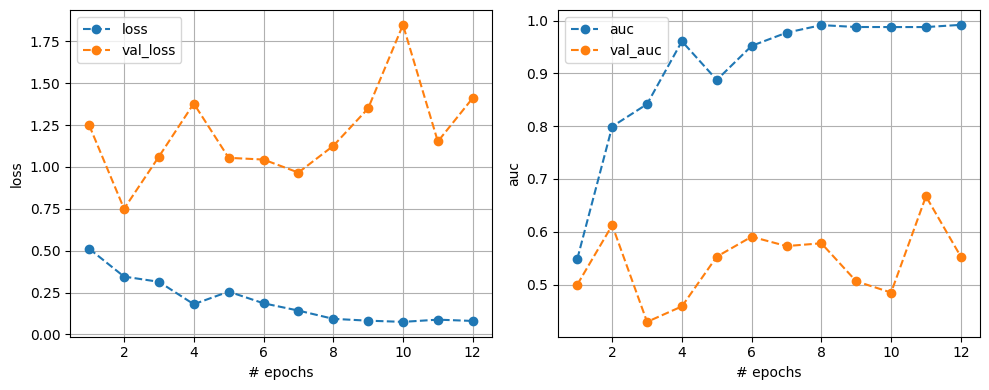

17/17 [==============================] - 5s 235ms/step - loss: 0.0805 - auc: 0.9920 - val_loss: 1.4109 - val_auc: 0.5529
Training time: 95.1275315284729 seconds


In [45]:
# Entrenamiento de la red
resnet_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
resnet_checkpoint = ModelCheckpoint('resnet50_best_weights.h5', save_best_only=True, save_weights_only=True)
resnet_plot_callback = PlotLearning()

start = time.time()

history = model_resnet50.fit(train_data_augmented, 
                    epochs=150, 
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data, 
                    callbacks=[resnet_callback, resnet_checkpoint, resnet_plot_callback],
                    #class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Max Sensitivity at Specificity >= 0.84: 0.19


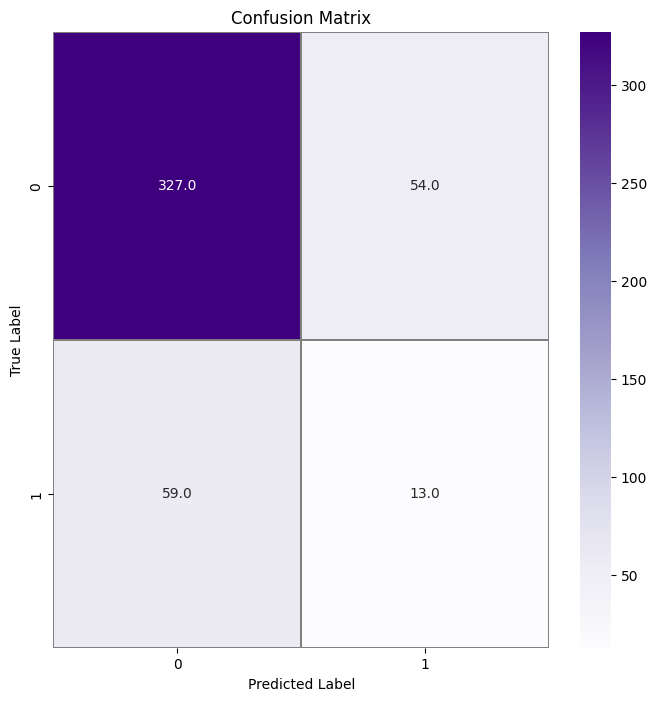

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       381
           1       0.19      0.18      0.19        72

    accuracy                           0.75       453
   macro avg       0.52      0.52      0.52       453
weighted avg       0.74      0.75      0.75       453

             Model Name  Max Sensitivity at Specificity 0.84   AUC  \
0  ResNet50-no-TL-no-CW                                 0.19  0.52   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                     0.19      0.75         0.18         0.86  0.19  0.85   

    PLR   NLR  
0  1.27  0.95  


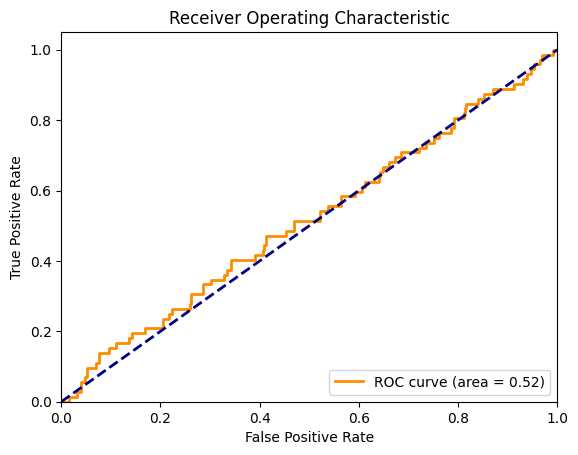

In [46]:
get_model_metrics(test_data=prep_test_data, model=model_resnet50, model_name='ResNet50-no-TL-no-CW')

# RESNET50 TRANSFER LEARNING

### With class weights

In [47]:
# cargar modelo
base_model_resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model_resnet50 = build_model(base_model=base_model_resnet50, transfer_learning='Y')

# Model summary
model_resnet50.summary()

base_model.trainable set to False
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grayscale_input (InputLaye  [(None, 224, 224, 1)]     0         
 r)                                                              
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 3)       30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 23589791 (8

In [48]:
# Compilación de la red
model_resnet50.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

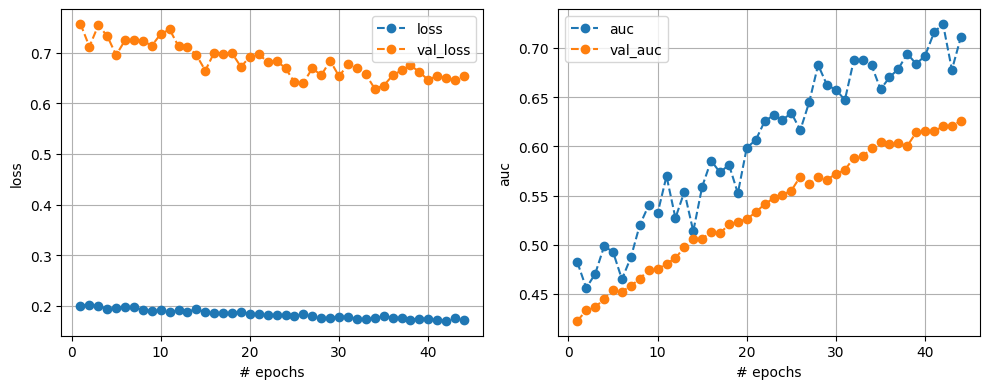

17/17 [==============================] - 4s 207ms/step - loss: 0.1713 - auc: 0.7108 - val_loss: 0.6528 - val_auc: 0.6258
Training time: 219.46505331993103 seconds


In [49]:
# Entrenamiento de la red
resnet_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
resnet_tl_checkpoint = ModelCheckpoint('resnet50_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
resnet_tl_plot_callback = PlotLearning()

start = time.time()

history = model_resnet50.fit(train_data_augmented, 
                    epochs=150, 
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data, 
                    callbacks=[resnet_tl_callback, resnet_tl_checkpoint, resnet_tl_plot_callback],
                    class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Max Sensitivity at Specificity >= 0.84: 0.24


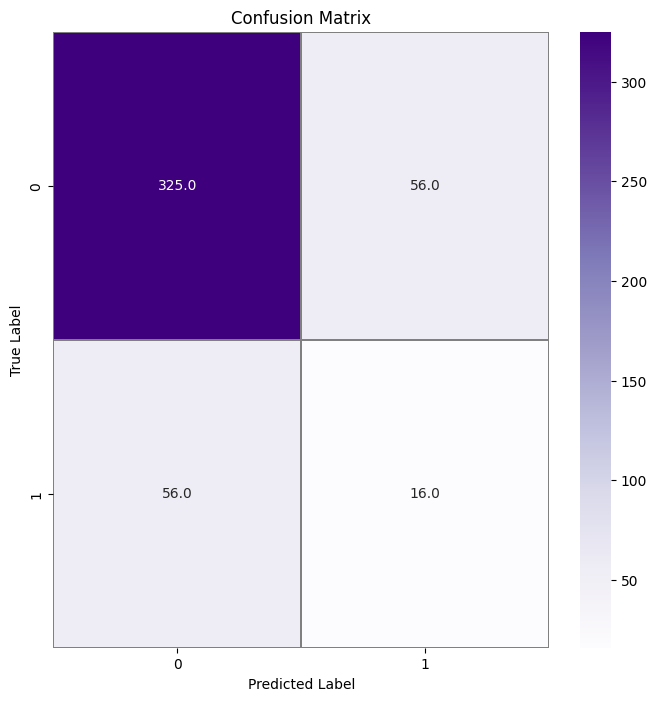

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       381
           1       0.22      0.22      0.22        72

    accuracy                           0.75       453
   macro avg       0.54      0.54      0.54       453
weighted avg       0.75      0.75      0.75       453

    Model Name  Max Sensitivity at Specificity 0.84   AUC  \
0  ResNet50-TL                                 0.24  0.52   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                     0.22      0.75         0.22         0.85  0.22  0.85   

    PLR   NLR  
0  1.51  0.91  


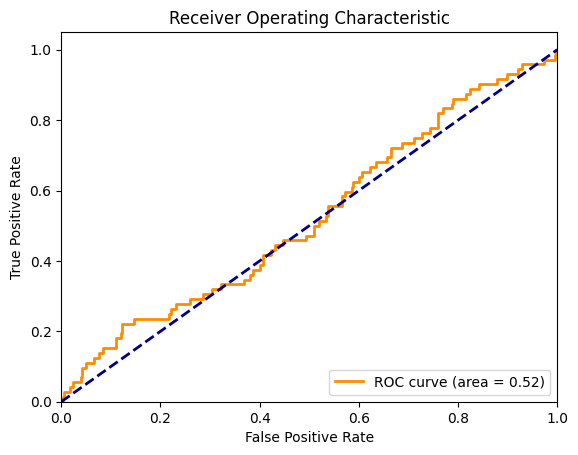

In [50]:
get_model_metrics(test_data=prep_test_data, model=model_resnet50, model_name='ResNet50-TL')

### Without class weights

In [51]:
# cargar modelo
base_model_resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model_resnet50 = build_model(base_model=base_model_resnet50, transfer_learning='Y')

# Compilación de la red
model_resnet50.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to False


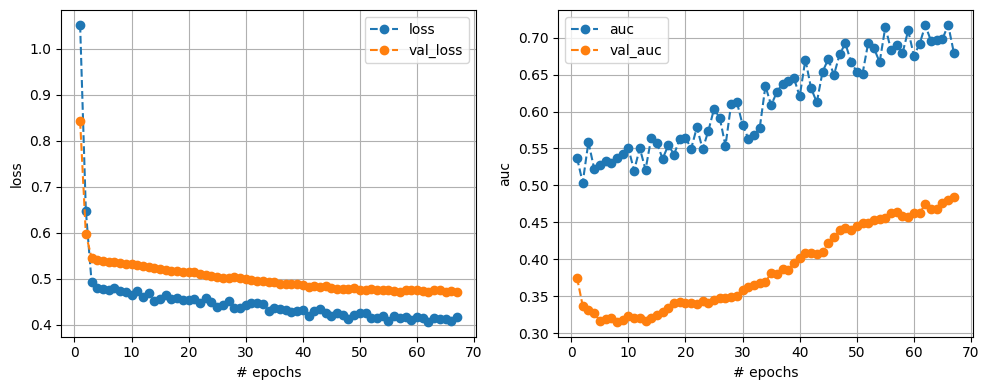

17/17 [==============================] - 4s 210ms/step - loss: 0.4170 - auc: 0.6796 - val_loss: 0.4724 - val_auc: 0.4836
Training time: 344.59327697753906 seconds


In [52]:
# Entrenamiento de la red
resnet_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
resnet_tl_checkpoint = ModelCheckpoint('resnet50_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
resnet_tl_plot_callback = PlotLearning()

start = time.time()

history = model_resnet50.fit(train_data_augmented, 
                    epochs=150, 
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data, 
                    callbacks=[resnet_tl_callback, resnet_tl_checkpoint, resnet_tl_plot_callback],
                    #class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Max Sensitivity at Specificity >= 0.84: 0.14


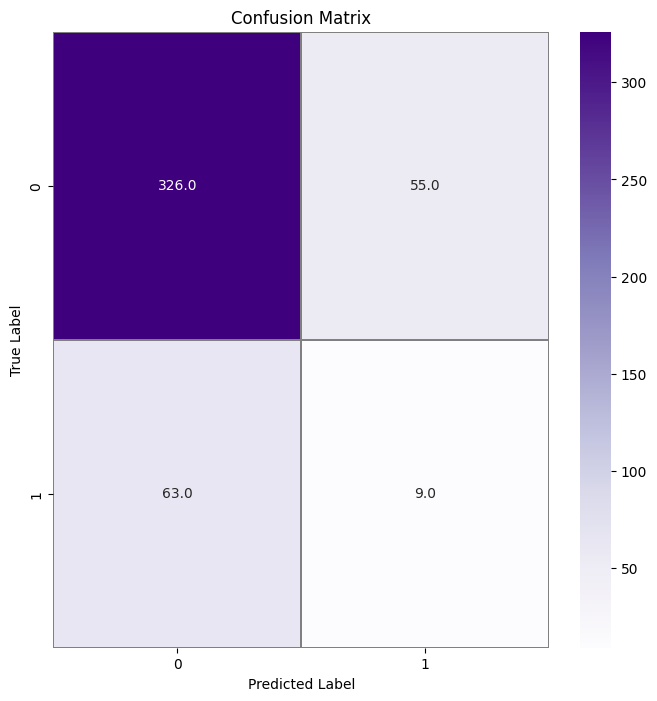

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       381
           1       0.14      0.12      0.13        72

    accuracy                           0.74       453
   macro avg       0.49      0.49      0.49       453
weighted avg       0.73      0.74      0.73       453

          Model Name  Max Sensitivity at Specificity 0.84   AUC  \
0  ResNet50-TL-no-CW                                 0.14  0.51   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                     0.13      0.74         0.12         0.86  0.14  0.84   

    PLR   NLR  
0  0.87  1.02  


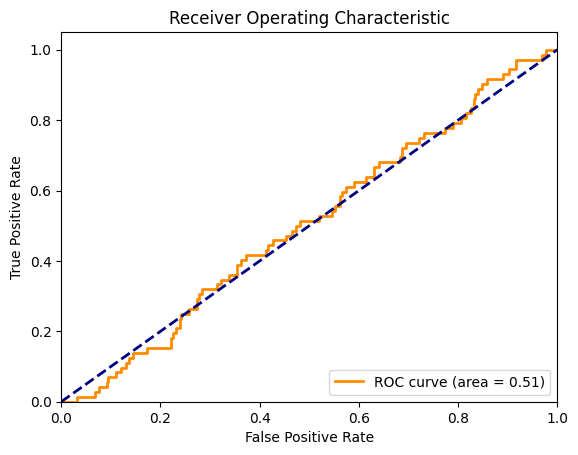

In [53]:
get_model_metrics(test_data=prep_test_data, model=model_resnet50, model_name='ResNet50-TL-no-CW')

# MobileNet (no TL)

In [54]:
from tensorflow.keras.applications import MobileNet

In [55]:
def preprocess_data_mobilenet(image, label):
    # Preprocess the image for MobileNet
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    return image, label

# Map the preprocessing function to the datasets
prep_train_data = train_data.map(preprocess_data_mobilenet)
prep_val_data = val_data.map(preprocess_data_mobilenet)
prep_test_data = test_data.map(preprocess_data_mobilenet)


In [56]:
train_data_augmented = prep_train_data.map(augment_image)

### With class weights

In [57]:
# load the model
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# build the model
model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='N')

# model summary
model_mobilenet.summary()

17225924/17225924 [==============================] - 0s 0us/step
base_model.trainable set to True
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grayscale_input (InputLaye  [(None, 224, 224, 1)]     0         
 r)                                                              
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 3)       30        
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_8  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)          

In [58]:
# Compilación de la red
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

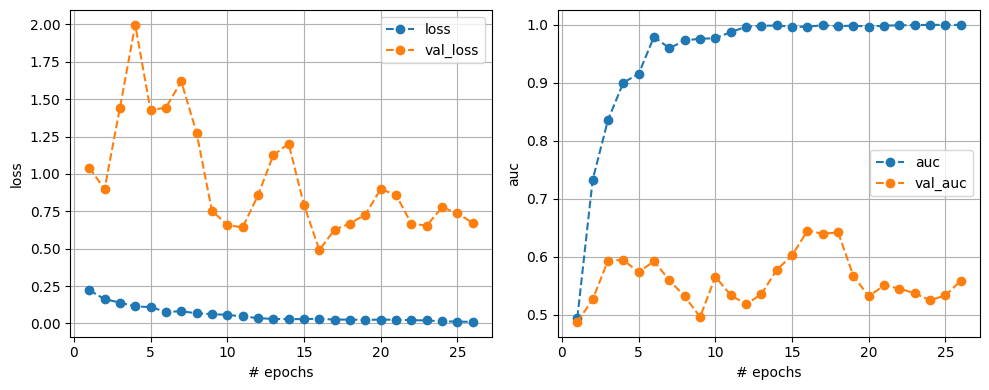

17/17 [==============================] - 3s 136ms/step - loss: 0.0107 - auc: 0.9999 - val_loss: 0.6723 - val_auc: 0.5587
Training time: 105.48862838745117 seconds


In [59]:
# Entrenamiento de la red
mob_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mob_checkpoint = ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)
mob_plot_callback = PlotLearning()

start = time.time()

history = model_mobilenet.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[mob_callback, mob_checkpoint, mob_plot_callback],
                    class_weight=class_weights_dict
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Max Sensitivity at Specificity >= 0.84: 0.17


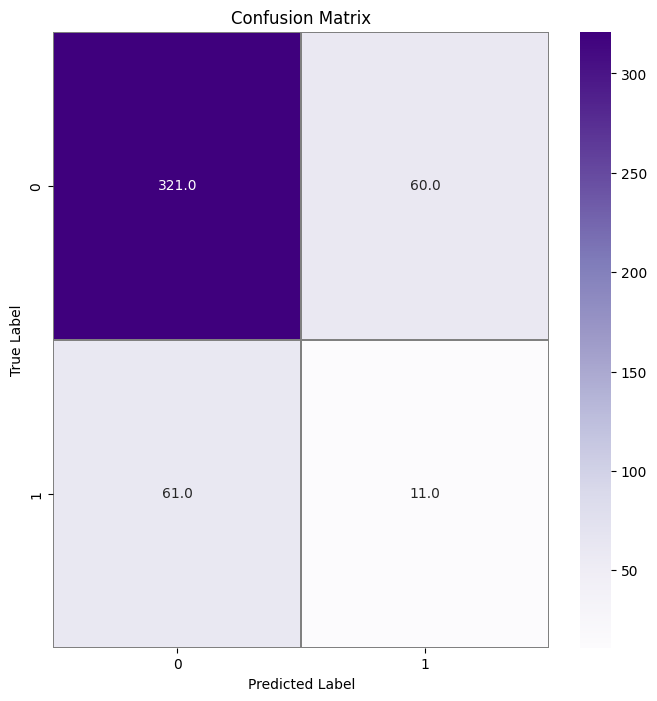

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       381
           1       0.15      0.15      0.15        72

    accuracy                           0.73       453
   macro avg       0.50      0.50      0.50       453
weighted avg       0.73      0.73      0.73       453

        Model Name  Max Sensitivity at Specificity 0.84   AUC  \
0  MobileNet-no-TL                                 0.17  0.51   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                     0.15      0.73         0.15         0.84  0.15  0.84   

    PLR   NLR  
0  0.97  1.01  


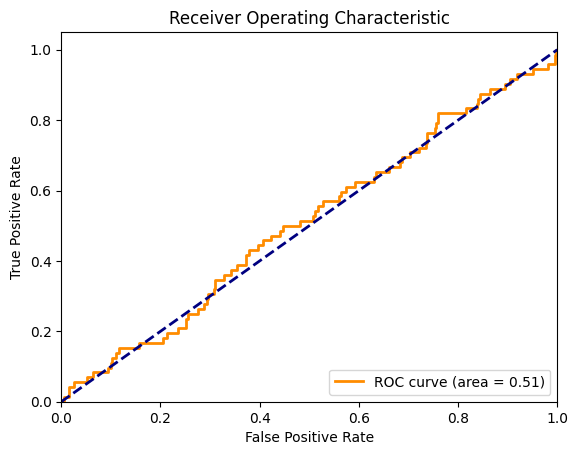

In [60]:
get_model_metrics(test_data=prep_test_data, model=model_mobilenet, model_name='MobileNet-no-TL')

### Without class weights

In [61]:
# load the model
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# build the model
model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='N')

# Compilación de la red
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to True


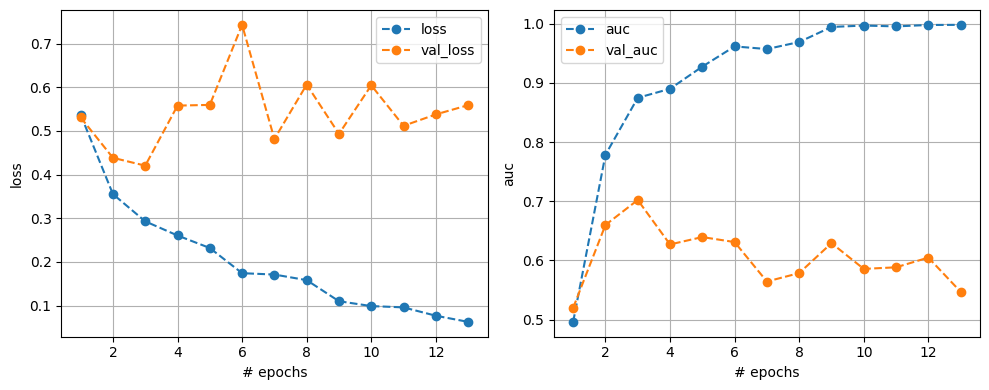

17/17 [==============================] - 3s 147ms/step - loss: 0.0629 - auc: 0.9982 - val_loss: 0.5589 - val_auc: 0.5471
Training time: 54.53284025192261 seconds


In [62]:
# Entrenamiento de la red
mob_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mob_checkpoint = ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)
mob_plot_callback = PlotLearning()

start = time.time()

history = model_mobilenet.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[mob_callback, mob_checkpoint, mob_plot_callback],
                    #class_weight=class_weights_dict
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Max Sensitivity at Specificity >= 0.84: 0.28


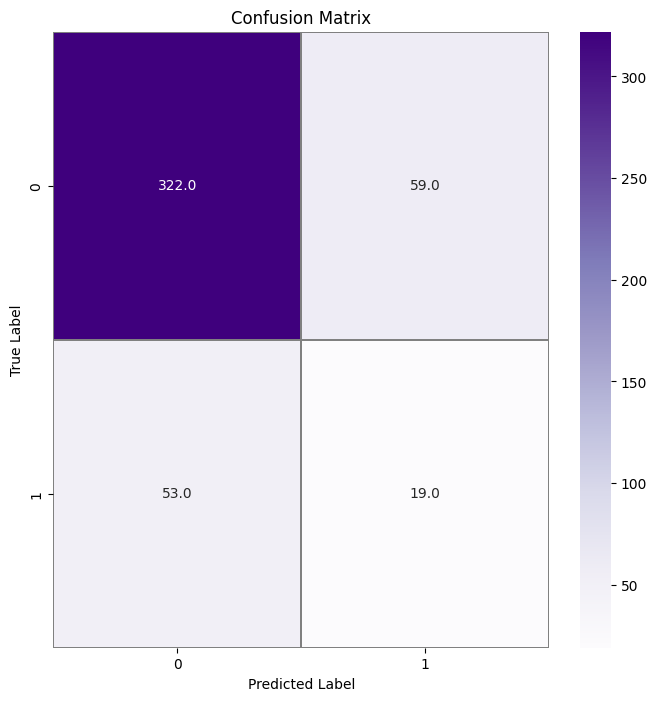

              precision    recall  f1-score   support

           0       0.86      0.85      0.85       381
           1       0.24      0.26      0.25        72

    accuracy                           0.75       453
   macro avg       0.55      0.55      0.55       453
weighted avg       0.76      0.75      0.76       453

              Model Name  Max Sensitivity at Specificity 0.84   AUC  \
0  MobileNet-no-TL-no-CW                                 0.28  0.62   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                     0.25      0.75         0.26         0.85  0.24  0.86   

   PLR   NLR  
0  1.7  0.87  


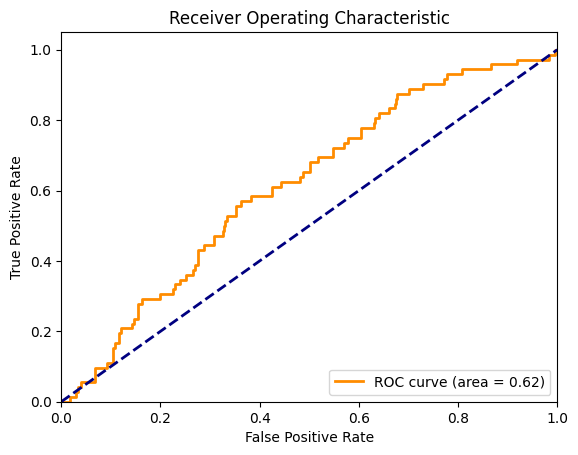

In [63]:
get_model_metrics(test_data=prep_test_data, model=model_mobilenet, model_name='MobileNet-no-TL-no-CW')

# MobileNet (TL)

### With class weights

In [64]:
# load the model
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# build the model
model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='Y')

# model summary
model_mobilenet.summary()

base_model.trainable set to False
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grayscale_input (InputLaye  [(None, 224, 224, 1)]     0         
 r)                                                              
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 3)       30        
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dense_14 (Dense)            (None, 1)                 1025      
                        

In [65]:
# Compilación de la red
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

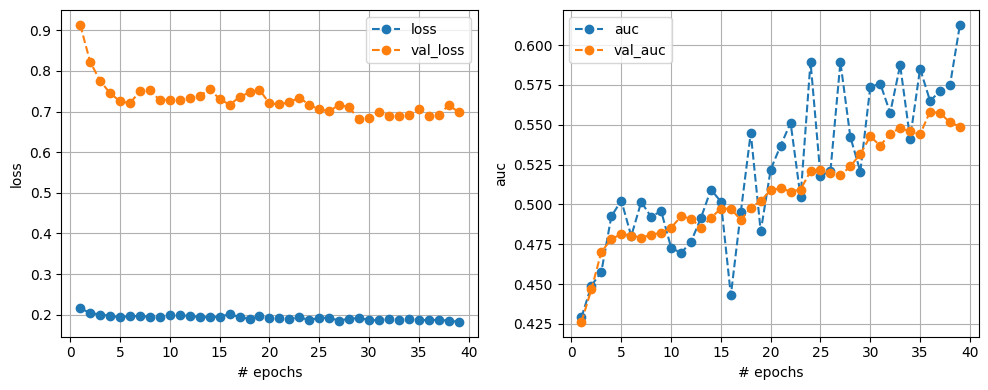

17/17 [==============================] - 3s 139ms/step - loss: 0.1824 - auc: 0.6128 - val_loss: 0.6985 - val_auc: 0.5489
Training time: 137.01905727386475 seconds


In [66]:
# Entrenamiento de la red
mob_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mob_checkpoint = ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)
mob_plot_callback = PlotLearning()

start = time.time()

history = model_mobilenet.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[mob_callback, mob_checkpoint, mob_plot_callback],
                    class_weight=class_weights_dict
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Max Sensitivity at Specificity >= 0.84: 0.08


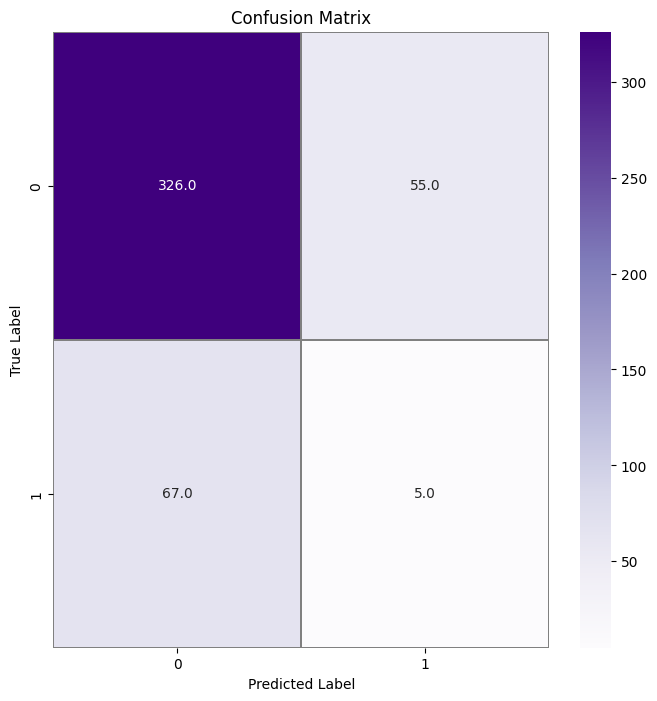

              precision    recall  f1-score   support

           0       0.83      0.86      0.84       381
           1       0.08      0.07      0.08        72

    accuracy                           0.73       453
   macro avg       0.46      0.46      0.46       453
weighted avg       0.71      0.73      0.72       453

     Model Name  Max Sensitivity at Specificity 0.84   AUC  \
0  MobileNet-TL                                 0.08  0.45   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                     0.08      0.73         0.07         0.86  0.08  0.83   

    PLR   NLR  
0  0.48  1.09  


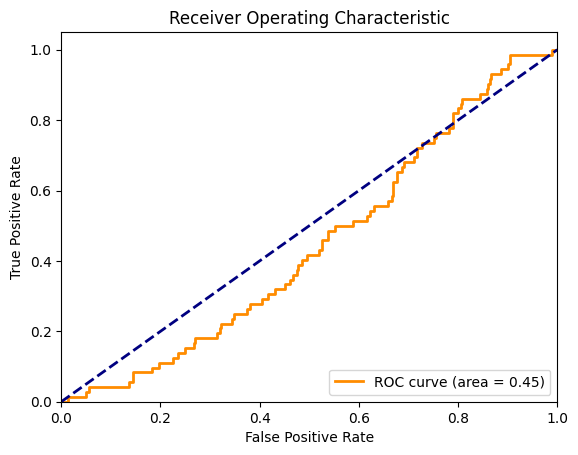

In [67]:
get_model_metrics(test_data=prep_test_data, model=model_mobilenet, model_name='MobileNet-TL')

### Without class weights

In [68]:
# load the model
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# build the model
model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='Y')

# Compilación de la red
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to False


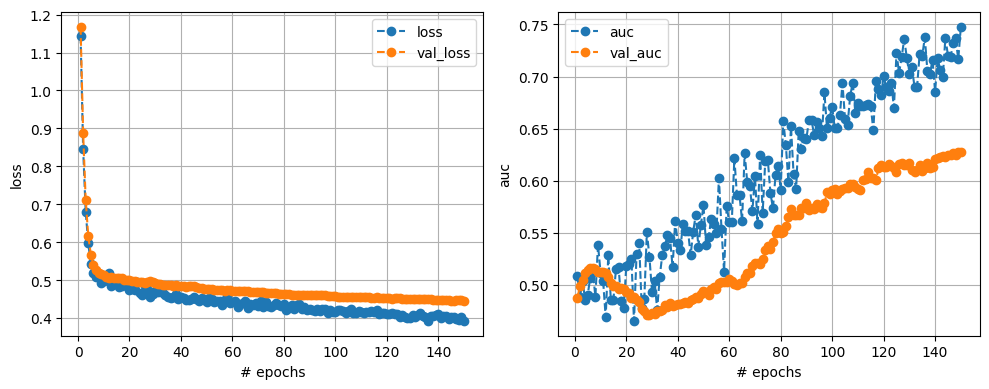

17/17 [==============================] - 3s 139ms/step - loss: 0.3921 - auc: 0.7474 - val_loss: 0.4452 - val_auc: 0.6276
Training time: 490.22474193573 seconds


In [69]:
# Entrenamiento de la red
mob_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mob_checkpoint = ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)
mob_plot_callback = PlotLearning()

start = time.time()

history = model_mobilenet.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[mob_callback, mob_checkpoint, mob_plot_callback],
                    #class_weight=class_weights_dict
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Max Sensitivity at Specificity >= 0.84: 0.08


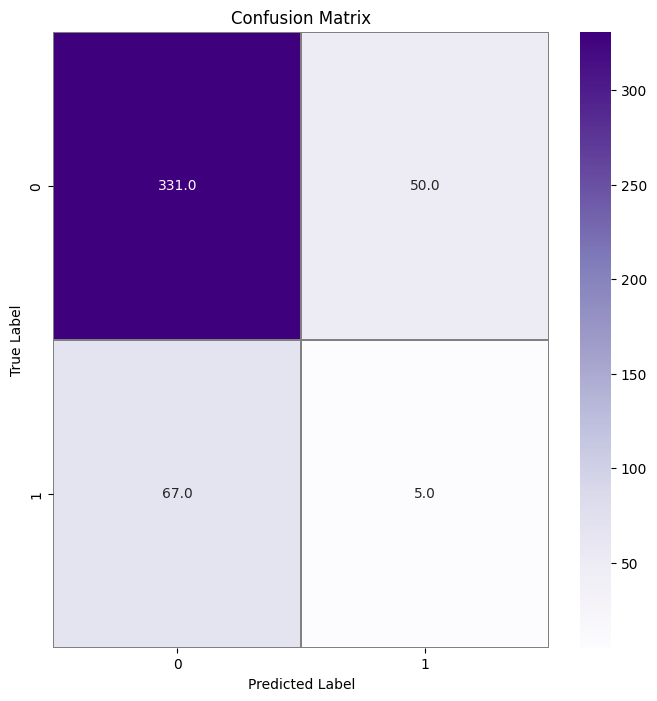

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       381
           1       0.09      0.07      0.08        72

    accuracy                           0.74       453
   macro avg       0.46      0.47      0.46       453
weighted avg       0.71      0.74      0.73       453

           Model Name  Max Sensitivity at Specificity 0.84   AUC  \
0  MobileNet-TL-no-CW                                 0.08  0.52   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                     0.08      0.74         0.07         0.87  0.09  0.83   

    PLR   NLR  
0  0.53  1.07  


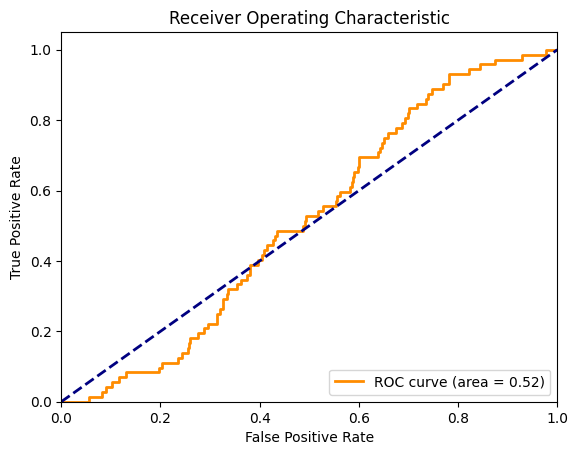

In [70]:
get_model_metrics(test_data=prep_test_data, model=model_mobilenet, model_name='MobileNet-TL-no-CW')

# ResNet18 (no TL)

In [71]:
!pip install image-classifiers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00


In [72]:
from classification_models.tfkeras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')

In [73]:
def preprocess_data_resnet18(image, label):
    image = preprocess_input(image)
    return image, label

prep_train_data = train_data.map(preprocess_data_resnet18)
prep_val_data = val_data.map(preprocess_data_resnet18)
prep_test_data = test_data.map(preprocess_data_resnet18)

In [74]:
train_data_augmented = prep_train_data.map(augment_image)

### With class weights

In [75]:
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='N')

# Compilación de la red
model_resnet18.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

44920640/44920640 [==============================] - 0s 0us/step
base_model.trainable set to True


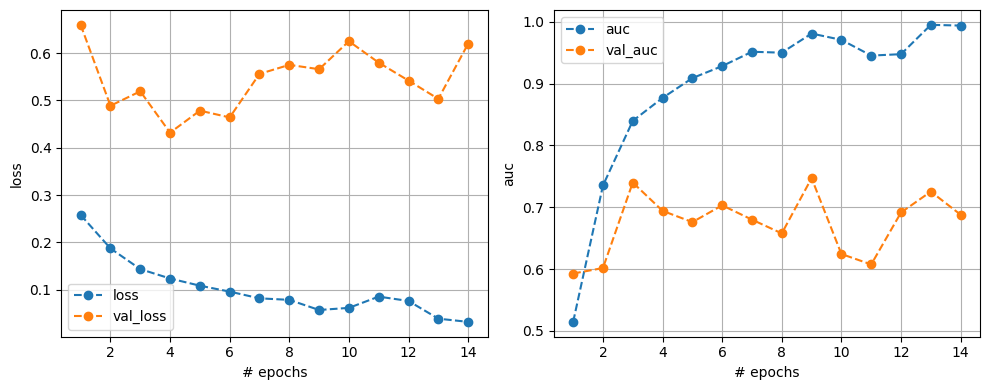

17/17 [==============================] - 3s 139ms/step - loss: 0.0324 - auc: 0.9938 - val_loss: 0.6195 - val_auc: 0.6880


In [76]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    class_weight=class_weights_dict
                    )

Max Sensitivity at Specificity >= 0.84: 0.11


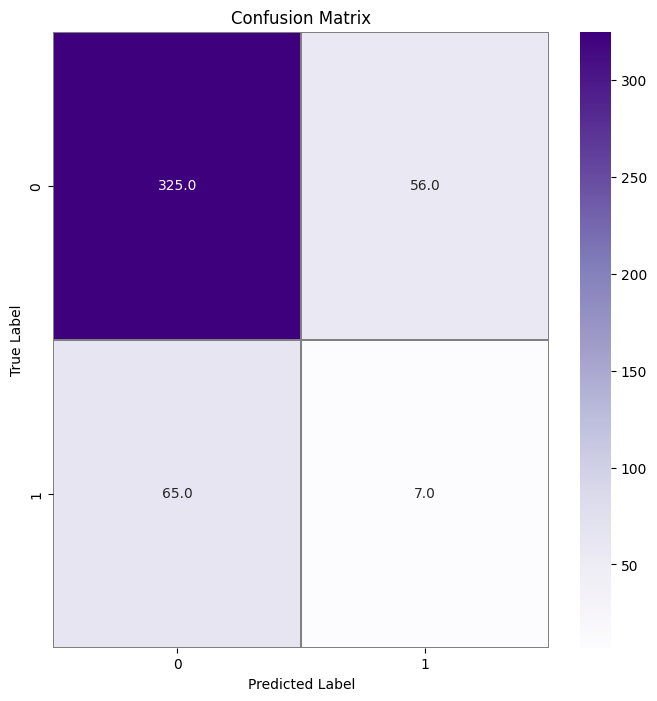

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       381
           1       0.11      0.10      0.10        72

    accuracy                           0.73       453
   macro avg       0.47      0.48      0.47       453
weighted avg       0.72      0.73      0.73       453

       Model Name  Max Sensitivity at Specificity 0.84   AUC  \
0  ResNet18-no-TL                                 0.11  0.47   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                      0.1      0.73          0.1         0.85  0.11  0.83   

    PLR   NLR  
0  0.66  1.06  


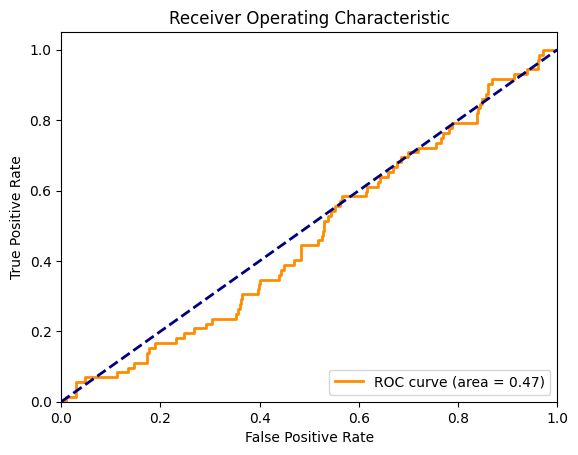

In [77]:
get_model_metrics(test_data=prep_test_data, model=model_resnet18, model_name='ResNet18-no-TL')

### Without class weights

In [78]:
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='N')

# Compilación de la red
model_resnet18.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to True


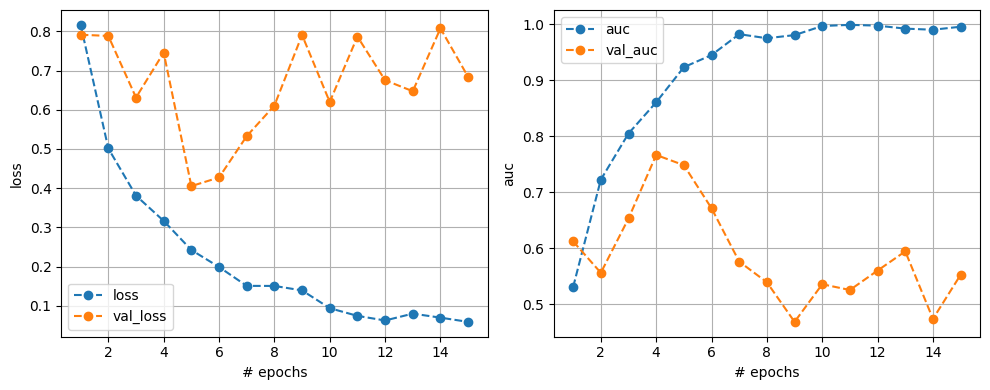

17/17 [==============================] - 3s 139ms/step - loss: 0.0587 - auc: 0.9955 - val_loss: 0.6840 - val_auc: 0.5529


In [79]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    #class_weight=class_weights_dict
                    )

Max Sensitivity at Specificity >= 0.84: 0.22


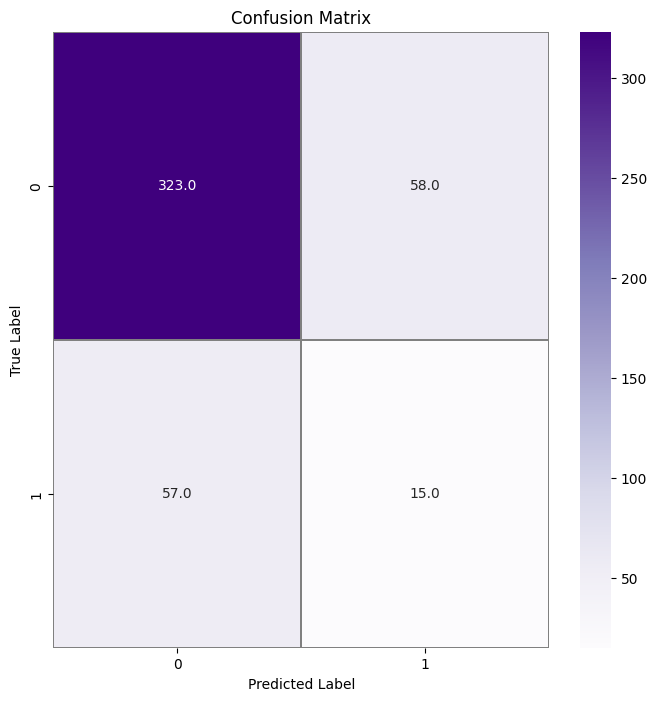

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       381
           1       0.21      0.21      0.21        72

    accuracy                           0.75       453
   macro avg       0.53      0.53      0.53       453
weighted avg       0.75      0.75      0.75       453

             Model Name  Max Sensitivity at Specificity 0.84   AUC  \
0  ResNet18-no-TL-no-CW                                 0.22  0.54   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                     0.21      0.75         0.21         0.85  0.21  0.85   

    PLR   NLR  
0  1.37  0.93  


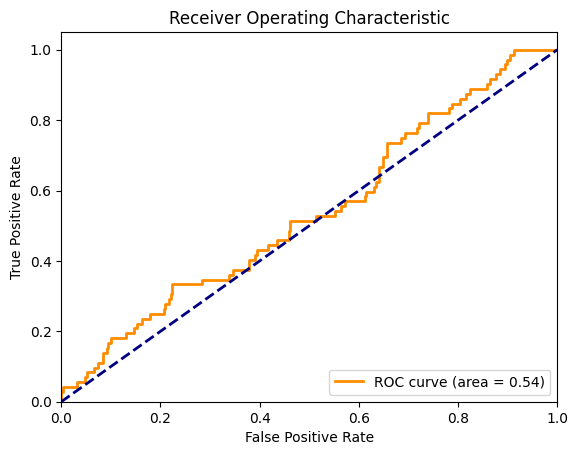

In [80]:
get_model_metrics(test_data=prep_test_data, model=model_resnet18, model_name='ResNet18-no-TL-no-CW')

# ResNet18 (TL)

### With class weights

In [81]:
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y')

# Compilación de la red
model_resnet18.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to False


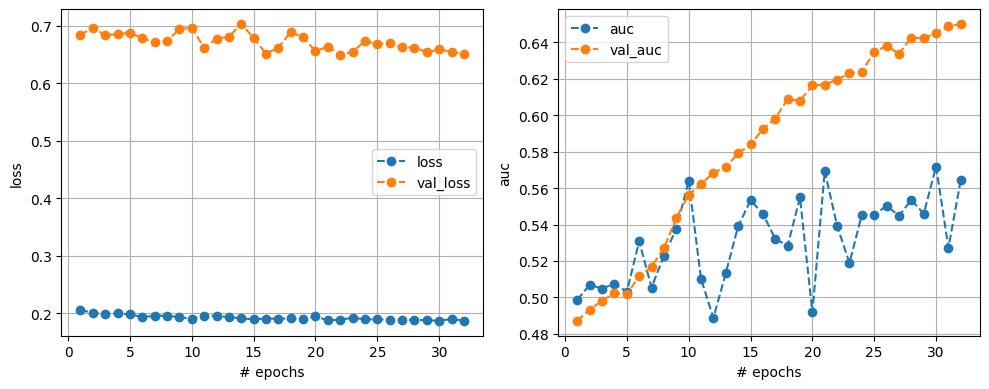

17/17 [==============================] - 4s 172ms/step - loss: 0.1868 - auc: 0.5647 - val_loss: 0.6507 - val_auc: 0.6502


In [82]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    class_weight=class_weights_dict
                    )

Max Sensitivity at Specificity >= 0.84: 0.15


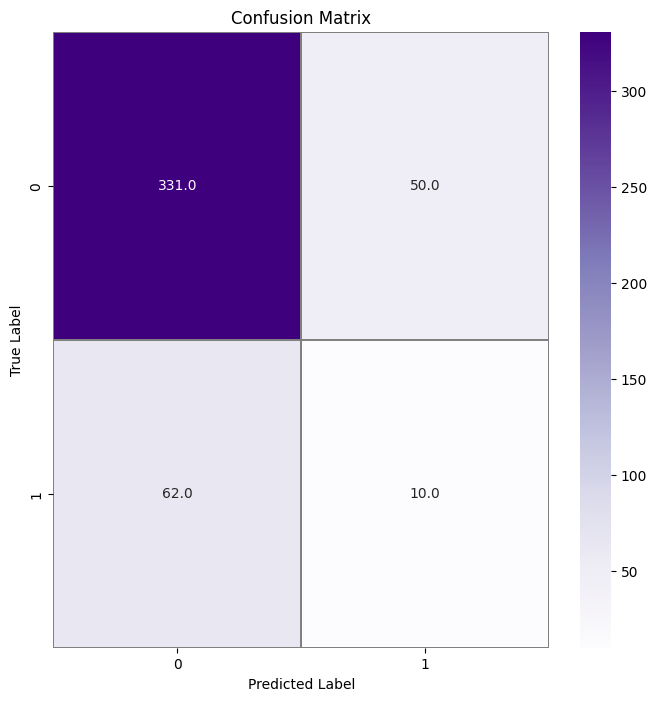

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       381
           1       0.17      0.14      0.15        72

    accuracy                           0.75       453
   macro avg       0.50      0.50      0.50       453
weighted avg       0.73      0.75      0.74       453

    Model Name  Max Sensitivity at Specificity 0.84  AUC  \
0  ResNet18-TL                                 0.15  0.5   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                     0.15      0.75         0.14         0.87  0.17  0.84   

    PLR   NLR  
0  1.06  0.99  


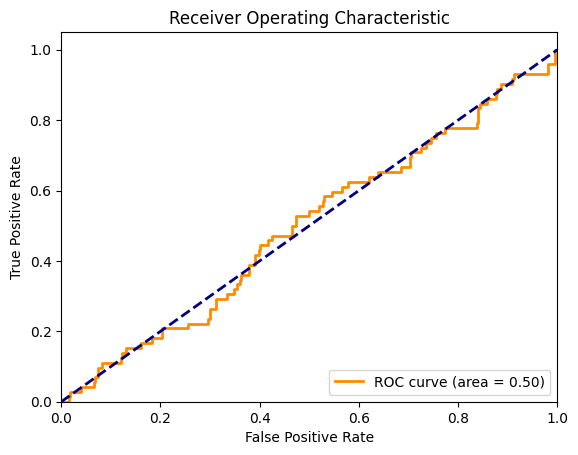

In [83]:
get_model_metrics(test_data=prep_test_data, model=model_resnet18, model_name='ResNet18-TL')

### Without class weights

In [84]:
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y')

# Compilación de la red
model_resnet18.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to False


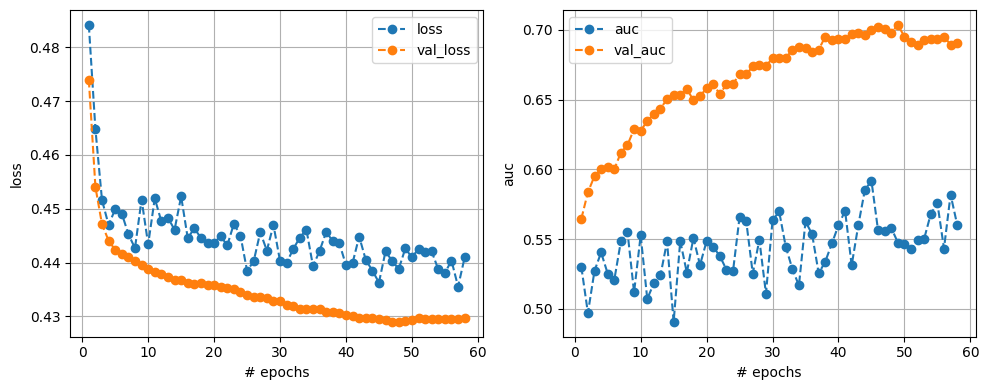

17/17 [==============================] - 3s 133ms/step - loss: 0.4410 - auc: 0.5603 - val_loss: 0.4297 - val_auc: 0.6902


In [85]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    #class_weight=class_weights_dict
                    )

Max Sensitivity at Specificity >= 0.84: 0.21


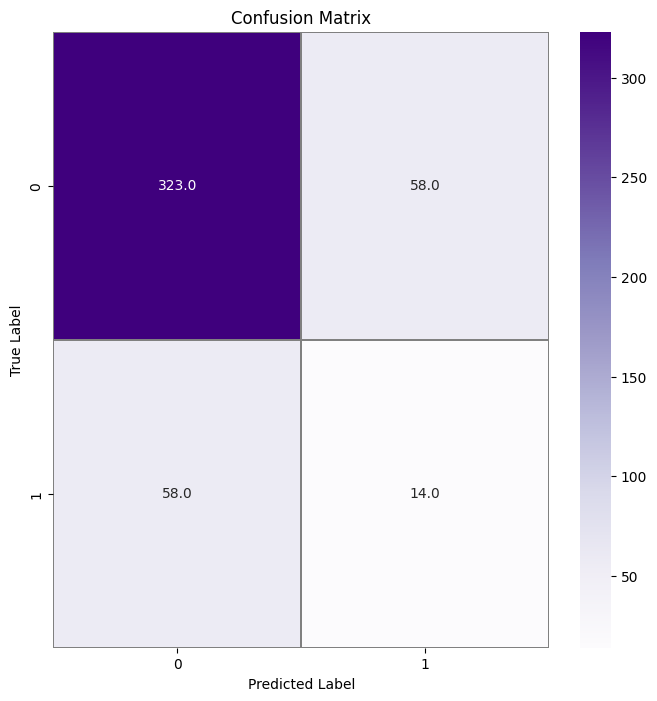

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       381
           1       0.19      0.19      0.19        72

    accuracy                           0.74       453
   macro avg       0.52      0.52      0.52       453
weighted avg       0.74      0.74      0.74       453

          Model Name  Max Sensitivity at Specificity 0.84   AUC  \
0  ResNet18-TL-no-CW                                 0.21  0.51   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                     0.19      0.74         0.19         0.85  0.19  0.85   

    PLR   NLR  
0  1.28  0.95  


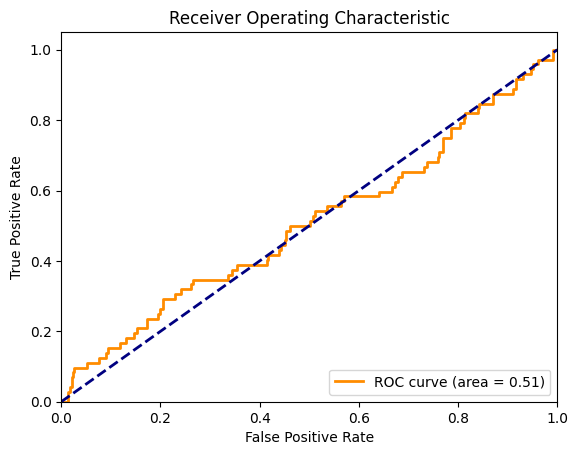

In [86]:
get_model_metrics(test_data=prep_test_data, model=model_resnet18, model_name='ResNet18-TL-no-CW')